In [3]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import random
import os
import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms.functional import to_pil_image

from sklearn.metrics import confusion_matrix

In [4]:
def data_augmentation(rot=25, crop=True, hflip=True, vflip=True):
    transform_list = []
    # if rot:
    #     transform_list.append(transforms.RandomRotation(rot))
    # if hflip:
    #     transform_list.append(transforms.RandomHorizontalFlip())
    # if vflip:
    #     transform_list.append(transforms.RandomVerticalFlip())

    transform_list.append(transforms.ToTensor())
    transform_list.append(transforms.Normalize((0.1307,), (0.3081,)))

    return transforms.Compose(transform_list)

In [5]:
class FashionMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        data = csv_file.values
        self.labels = data[:, 0]
        self.images = data[:, 1:].reshape(-1, 28, 28).astype(np.uint8)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]
        image = Image.fromarray(image)  # Convert numpy to PIL

        if self.transform:
            image = self.transform(image)

        return image, label

# Load data from csv
from torch.utils.data import random_split


train_csv = pd.read_csv("../data/fashion-mnist_train.csv")
test_csv = pd.read_csv("../data/fashion-mnist_test.csv")
train_set = FashionMNISTDataset(train_csv, transform = data_augmentation())
test_set = FashionMNISTDataset(test_csv, transform =  data_augmentation())
train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_set, val_set = random_split(train_set, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
val_loader = DataLoader(val_set, batch_size = 32, shuffle=True)

print("Train set size:", len(train_set))
print("Validation set size:", len(val_set))
print("Test set size:", len(test_set))

Train set size: 48000
Validation set size: 12000
Test set size: 10000


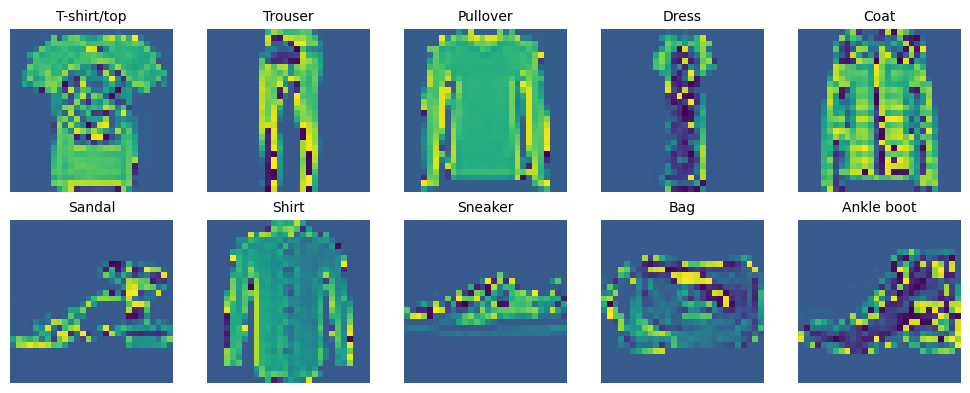

In [6]:
#class mapping
class_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

def show_one_per_class(dataset, class_names=None, num_classes=None, rows=2, cols=5):

    seen = {}
    indices = list(range(len(dataset)))
    random.shuffle(indices)

    for idx in indices:
        _, label = dataset[idx]
        label = int(label)
        if label not in seen:
            seen[label] = idx
        if num_classes and len(seen) >= num_classes:
            break

    # Sort the labels for consistent display
    sorted_items = sorted(seen.items(), key=lambda x: x[0])
    total = len(sorted_items)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i, (label, idx) in enumerate(sorted_items):
        image, _ = dataset[idx]

        if isinstance(image, torch.Tensor):
            image = image.clone()
            image = image * 0.5 + 0.5  # unnormalize if needed
            image = to_pil_image(image)

        axes[i].imshow(image)
        axes[i].set_title(class_names[label] if class_names else f"Class {label}", fontsize=10)
        axes[i].axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

show_one_per_class(train_set, list(class_names.values()))

In [ ]:
class DNNv3